# Entrega 2

In [87]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [53]:
tf.__version__

'2.15.0'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [54]:
!mkdir data

mkdir: data: File exists


In [72]:
!curl https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/Semana%2003/data/b2w-10k.csv --output 'data/b2w-10k.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3919k  100 3919k    0     0  5460k      0 --:--:-- --:--:-- --:--:-- 5466k


In [73]:
b2wCorpus = pd.read_csv("data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [74]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object

In [75]:
b2wCorpus['overall_rating'] = b2wCorpus['overall_rating'] - 1
b2wCorpus["overall_rating"].value_counts()

overall_rating
4    3744
3    2503
0    1918
2    1216
1     618
Name: count, dtype: int64

In [115]:
novo_lwt = b2wCorpus[b2wCorpus['overall_rating'].isin([0, 1, 2, 3, 4])]
novo_lwt = novo_lwt[["review_text", "overall_rating"]]
texto = novo_lwt['review_text']
rating = novo_lwt['overall_rating']

train_review, test_review, train_labels, test_labels = train_test_split(
    texto, rating, test_size=0.25, random_state=42
)

In [111]:
test_labels

5344    3
7444    3
1731    4
8719    4
4521    3
       ..
9448    4
8284    4
7852    4
1095    1
8871    3
Name: overall_rating, Length: 2000, dtype: int64

## Tokenizando




In [116]:
max_tokens = 20000
output_sequence_length = 100
embedding_dim = 128

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int', 
    output_sequence_length=output_sequence_length,
)
vectorizer.adapt(train_review)
train_tokens = vectorizer(train_review)
test_tokens = vectorizer(test_review)

In [117]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_review, 
    train_labels, 
    epochs=50,
    batch_size=64,
    validation_data=(test_review, test_labels),
    callbacks=[early_stopping],
    verbose=1 
)

test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_15 (Tex  (None, 100)               0         
 tVectorization)                                                 
                                                                 
 embedding_32 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dense_64 (Dense)            (None, 128)               16512     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_65 (Dense)            (None, 5)                 645       
                                                     

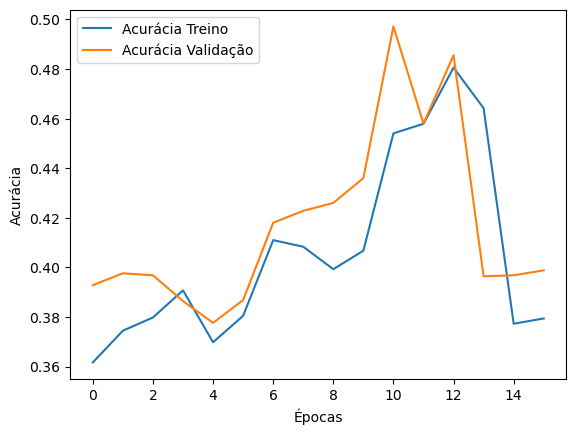

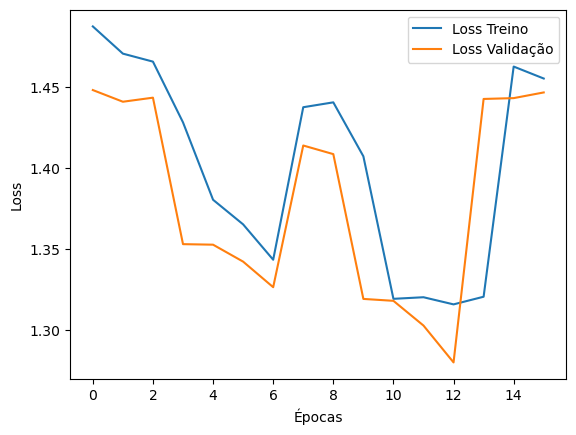

In [118]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [127]:
#GRU

model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.GRU(128, return_sequences=False),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_review, 
    train_labels, 
    epochs=11,
    batch_size=64,
    validation_data=(test_review, test_labels),
    callbacks=[early_stopping],
    verbose=1 
)

test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Tex  (None, 100)               0         
 tVectorization)                                                 
                                                                 
 embedding_37 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 gru_18 (GRU)                (None, 128)               99072     
                                                                 
 dense_74 (Dense)            (None, 128)               16512     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 5)                 645       
                                                     

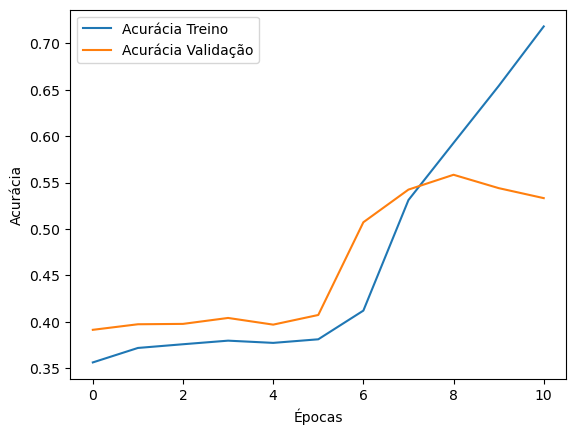

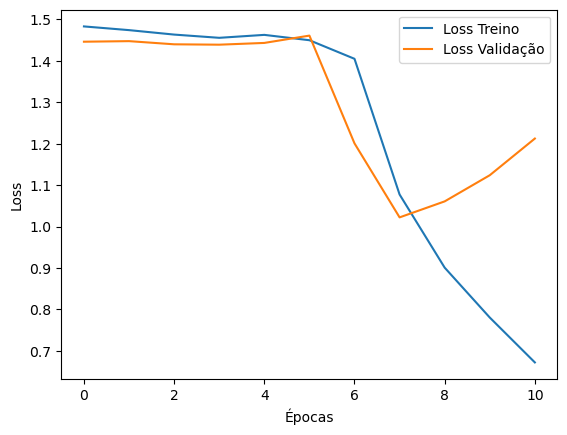

In [121]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [122]:
max_tokens = 20000
output_sequence_length = 100
embedding_dim = 128

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int', 
    output_sequence_length=output_sequence_length,
)
vectorizer.adapt(train_review)
train_tokens = vectorizer(train_review)
test_tokens = vectorizer(test_review)

In [129]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_review, 
    train_labels, 
    epochs=50,
    batch_size=16,
    validation_data=(test_review, test_labels), 
    callbacks=[early_stopping],
    verbose=1 
)
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Tex  (None, 100)               0         
 tVectorization)                                                 
                                                                 
 embedding_39 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 bidirectional_15 (Bidirect  (None, 256)               263168    
 ional)                                                          
                                                                 
 dense_78 (Dense)            (None, 128)               32896     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_79 (Dense)            (None, 5)               

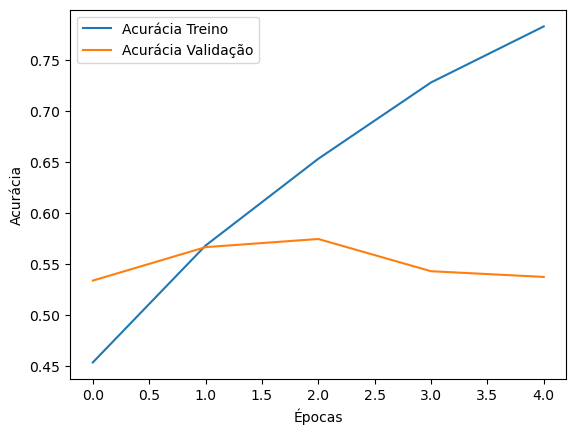

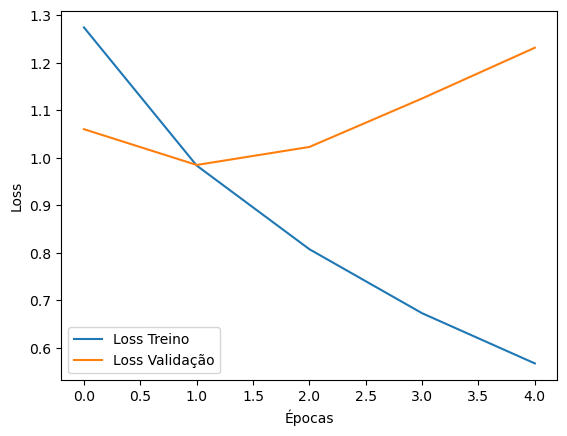

In [124]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [125]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.Bidirectional(layers.GRU(128, return_sequences=False)), 
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_review, 
    train_labels, 
    epochs=50,
    batch_size=64,
    validation_data=(test_review, test_labels), 
    callbacks=[early_stopping],
    verbose=1 
)
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Tex  (None, 100)               0         
 tVectorization)                                                 
                                                                 
 embedding_36 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 bidirectional_13 (Bidirect  (None, 256)               198144    
 ional)                                                          
                                                                 
 dense_72 (Dense)            (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 5)               

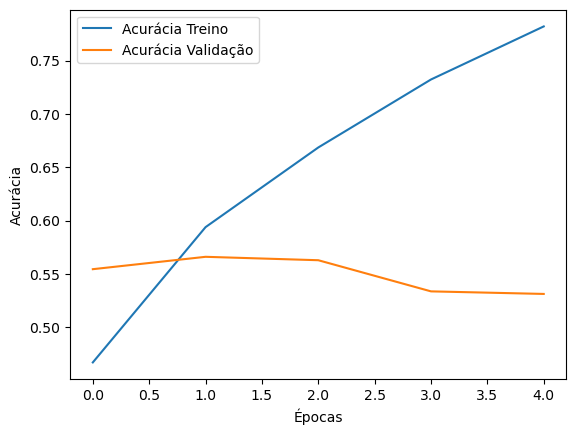

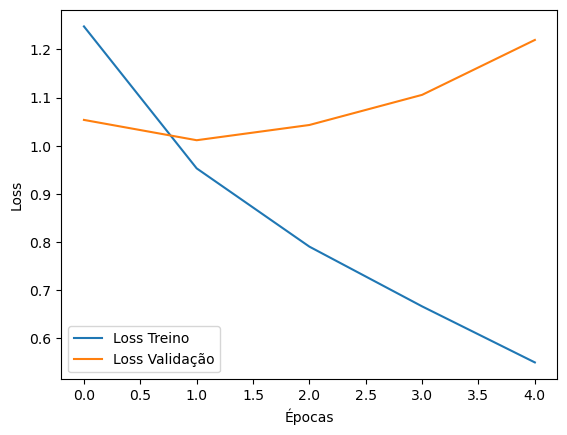

In [126]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()